$
\DeclareMathOperator{\Prob}{Pr}
\renewcommand{\vec}[1]{{\underline{#1}}}
\newcommand{\dott}[2]{{{#1}^T{#2}}}
\newcommand{\mat}[1]{{\mathbf{#1}}}
\def\code#1{\texttt{#1}}
$

# Programming Exercises - Set 3
    
In this exercises we will develop a class  `NNet` implementing a feed-forward neural network(NN).  We are going to use the datasets: **dataset2_linreg.py** and** dataset2_logreg.py** which were also used  in the precious exercises. Before using a dataset in Colab we need to upload it to the notebook: click on the black box [>] on the left to expand a menu; then go to Files and select upload.

1. Activation functions and their derivatives are extensively used in NNs during the forward- and back-propagation. Implement activation function and their darivatives. The functions should take a numpy array of arbitrary size and return a numpy array of the same size with activation function (or its derivative) applied elementwise.

In [1]:
# 激活函数返回值计算！！

def indentity(x):
    return x
   
def d_indentity(x):    # d表示微分  用于forward／back propagation
    return np.ones(x.shape)
  
def relu(x):
    return np.maximum(x, np.zeros(x.shape))

def d_relu(x):     # d表示微分 用于forward／back propagation
    return (x>0).astype(float)
  
def sigmoid(x):
    return 1/(1+np.exp(-x))

def d_sigmoid(x):   # d表示微分  用于forward／back propagation
    return sigmoid(x)*(1-sigmoid(x))

## Problem 1 - Regression with NNs
In this exercises we apply NNs to the regression problem. In the regression problem we are going to use the quadratic cost function and the identity activation function for the output layer. We are going to use  one-dimensional dataset: **dataset2_linreg.py**. 
The inputs in the dataset are organized as a matrix:
\begin{align}
\begin{bmatrix}
&{x}_1 &\dots &{x}_N
\end{bmatrix},
\end{align}
and the output in the dataset are organized as a matrix: 
\begin{align}
\begin{bmatrix}
&y_1 &\dots &y_N
\end{bmatrix}.
\end{align}
We start from implementing the cost function and ploting the dataset.

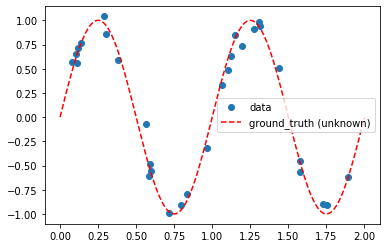

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from dataset2_linreg import DataSet  

#get and plot the data
y_D,x_D = DataSet.get_data()
DataSet.plot_data()
plt.show()

#cost L2
def l2_cost(x_D, y_D, predict_f):
    y_predicted = predict_f(x_D)
    return np.sum(0.5*(y_predicted-y_D)**2)     # quadratic cost function

In this step,  we build up a class representing called NNet which implements NN. Read the description of the class and implement the following methods:
>1. `init_Wb(self)`:  The function should initialize the matrices $\mat{W}^{[1]}, \dotsc, \mat{W}^{[L]}$ and the vectors $\vec{b}^{[1]}, \dotsc, \vec{b}^{[L]}$ with random numbers from Gaussian distribution with $0$ mean and $0.25$ variance.
>2. `fp(self, x):` The function performs forward propagation. Recall the forward propagation for a single input vector $\vec{x}$:
	\begin{align}
	&\vec{a}^{[0]} = \vec{x} \\
	&\vec{z}^{[l]} =  \mat{W}^{[l]} \vec{a}^{[l-1]} + \vec{b}^{[l]}\\
	&\vec{a}^{[l]} = g^{[l]}\left(\vec{z}^{[l]}\right).
	\end{align}
  The function `fp` should be more flexible and should allow at the input a sequence of input vectors which are collected in a matrix. That is, at the input it should take a matrix containing $n$ input vectors
  \begin{align} 
	\begin{bmatrix}
	\vec{x}_1, 			&\dotsc, 	&\vec{x}_n \\
	\end{bmatrix}.
	\end{align}
  The output consists of two dictionaries which contain the inputs to each layer (dictionary `z`) and the outputs from each layer (dictionary `a`). The key in the dictionary is the number of the layer. Note that we are using the numbering and notation from the lecture. The dictionaries should look like this:
\begin{align}
	\texttt{a = \{} & \texttt{0:} 
		\begin{bmatrix} \vec{x}_1, &\dotsc, &\vec{x}_N  \end{bmatrix}, \\
					&\texttt{1}: 
		\begin{bmatrix} \vec{a}^{[1]}(\vec{x}_1), &\dotsc, &\vec{a}^{[1]}(\vec{x}_N)  \end{bmatrix}, \\
					& \dotsc \\
					&\texttt{L}:
		\begin{bmatrix} \vec{a}^{[L]}(\vec{x}_1), &\dotsc, &\vec{a}^{[L]}(\vec{x}_N)  \end{bmatrix}\texttt{\}} 		
	\end{align}
	\begin{align}
		\texttt{z = \{} & \texttt{1:} 
		\begin{bmatrix} \vec{z}^{[1]}(\vec{x}_1), &\dotsc, &\vec{z}^{[1]}(\vec{x}_N)  \end{bmatrix}, \\
		&\texttt{2}: 
		\begin{bmatrix} \vec{z}^{[2]}(\vec{x}_1), &\dotsc, &\vec{z}^{[2]}(\vec{x}_N)  \end{bmatrix}, \\
		& \dotsc \\
		&\texttt{L}:
		\begin{bmatrix} \vec{z}^{[L]}(\vec{x}_1), &\dotsc, &\vec{z}^{[L]}(\vec{x}_N)  \end{bmatrix}\texttt{\}} 			
	\end{align}
  The reason why we store the inputs/outputs for each layer is that we will need them during the back-propagation.

  

In [4]:
class NNet:          # CNN 训练流程！！
    """
    Class implementing a feed forward neural network.
    Object fields:
        layers = a tuple containing numbers of neurons in each layer, starting from the input layer
        
        L = depth of the NN, eg, with depth L there are L matrices W: W[1], ...,W[L]
        
        act_hid   = activation function for neurons in the hidden layer
        d_act_hid = derivative of the activation function for neurons in the hidden layer
        act_out   = activation function for neuron(s) in the output layer
        d_act_out = derivative of the activation function for neuron(s) in the output layer        
        
        W = dictionary containing the W matrices for each layer. The keys are arranged such that the matrices 
            stored in the dictionary corresponds to the notation form the lecture. Ie, W[1] is the matrix which
            describes the connections between the layer 0 and layer 1. The matrix stored at W[1] is a numpy array
            with dimensions (number of neurons in the layer 1) x (number of neurons in the layer 0)          
        
        b = dictionary containing the b vectors for each layer. The indexing corresponds to the indexing from
            the lecture. See above. Eg, dimensions of b[1] (number of neurons in the layer 1) x  1   
    """	
    def __init__(self, layers, act_hid, d_act_hid, act_out, d_act_out):
        self.layers = layers
        self.L = len(layers) - 1
        self.act_hid = act_hid
        self.d_act_hid = d_act_hid        
        self.act_out = act_out
        self.d_act_out = d_act_out        
        self.W, self.b = self.init_Wb()
        
    def init_Wb(self):
        """
        Initialize the matrices W[1],...,W[L] and the vectors b[1],...,b[L] with random numbers from gaussian
        distribution with 0-mean, and 0.25 variance. Note that W, b are dictionaries with integer keys.
        """
        W, b = {}, {}
        for i in range(1,self.L+1):
        ###YOUR CODE HERE###   
            W[i] = np.random.normal(0,0.25,(self.layers[i],self.layers[i-1]))
            b[i] = np.random.normal(0,0.25,(self.layers[i],1))
   
        ####################
        return W, b
    
    def fp(self, x):      # 前向 Forward propagation ！！
        """
        Forward propagation. Uses the current parameters W, b
        Inputs:
            x = np.array of size self.layers[0] x N. This means that this function
                performs the forward propagation for N input vectors (columns).
        Outputs:
            a = dictionary containing output of each layer of NN. Each dictionary stores N outputs
                for each of the inputs. Eg., a[1] should be np.array of size self.layers[1] x N
                The indexing corresponds to the indexing from the lecture. E.g. a[0]=x because a[0] 
                contains the N outputs of the input layer, which is the input x.
            z = dictionary containing input to each layer of NN. The indexing corresponds to the indexing
                from the lecture. E.g. z[1]=W[1].dot(a[0])+b[1].
        """
        a, z = {}, {}
        ###YOUR CODE HERE###
        a[0] = x
        L = self.L
        for i in range(1,L):
            z[i] = self.W[i].dot(a[i-1]) + self.b[i]
            a[i] = self.act_hid(z[i])    
            
        z[L] = self.W[L].dot(a[L-1]) + self.b[L]    
        a[L] = self.act_out(z[L]) 

        ####################
        return a,z    
        
    def output(self, x):     #参数x_D从哪里导进来到x中的？
        """
        Provides the output from the last layer of NN.
        """
        a_out = None
        a, _ = self.fp(x)
        a_out = a[self.L]
        return a_out 

We now plot the model implemented by the NN and compute the cost.


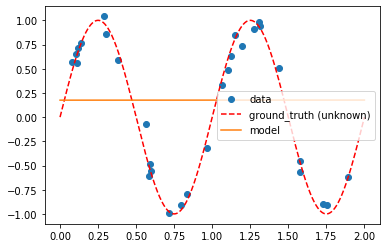

Cost:7.410412


In [5]:
NN = NNet((1,4,4,1), sigmoid, d_sigmoid, indentity, d_indentity)  
    
DataSet.plot_model(NN.output)
plt.show()
print('Cost:%f' % l2_cost(x_D, y_D, NN.output))  

We now add the backpropagation to class `NNet`. The algorithm is implemented for you. Take a look at the implementation and try to understand what is happening in the following steps. In the next exercise you will be asked to modify this function.

In [6]:
def bp(self, x, y):    # 后向  Backpropagation！！
    """
    Backpropagation. Uses the current parameters W, b
    Args:
        x = np.array of size self.layers[0] x N (contains N input vectors from the training set)
        y = np.array of size self.layers[L] x N (contains N output vectors from the training set)
    Returns:
        dW = dictionary corresponding to W, where each corresponding key contains a matrix of the 
             same size, eg, W[i].shape = dW[i].shape for all i. It contains the partial derivatives
             of the cost function with respect to each entry entry of W.
        db = dictionary corresponding to b, where each corresponding key contains a matrix of the 
             same size, eg, b[i].shape = bW[i].shape for all i. It contains the partial derivatives
             of the cost function with respect to each entry entry of b. 
        
    """
    a,z = self.fp(x)
    L = self.L
    
    dCdz = { L: a[L]-y }
    for l in range(L-1,0,-1):
        dCdz[l] = self.W[l+1].T.dot(dCdz[l+1]) * self.d_act_hid(z[l])
        
    db = {}
    for l in range(1,L+1):
        db[l] = np.sum(dCdz[l], axis=1).reshape((-1,1))
        
    dW = {}
    for l in range(1,L+1):
        dW[l] = dCdz[l].dot(a[l-1].T)
    return dW, db

  
#adding the back-prop to the class
NNet.bp = bp
  

3. Please implement the function for gradient descent learning. Use the already implemented back-propagation. Note that the function is a part of the class so you can use the class fields/functions by using the phrase `self`

In [7]:
def gd_learn(self, iter_num, l_rate, x, y):    # 梯度下降gradient descent！！ 得出最终的w，b参数
    """
    Performs gradient descent learning.
    iter_num = nubmer of interations of GD
    l_rate = learning rate
    x = nparray with the training inputs
    y = nparray with the training outputs
    """
    ### YOUR CODE HERE ###
    for i in range(iter_num):
        dW, db = self.bp(x, y)
        for n in range(1, self.L+1):
            self.W[n] = self.W[n] - l_rate*dW[n]
            self.b[n] = self.b[n] - l_rate*db[n]
      
    #####################
    return 0

#adding the gd_learn to the class
NNet.gd_learn = gd_learn  

We now initialize and train the NN (can take some time). Next, we plot the model.

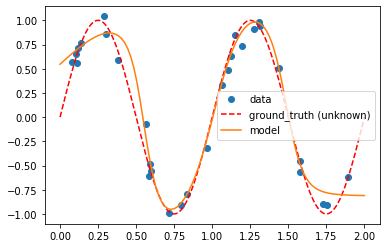

Cost:0.163553


In [8]:
NN.gd_learn(50000, 0.02, x_D, y_D)

#plot and compute cost
DataSet.plot_model(NN.output)
plt.show()
print('Cost:%f' % l2_cost(x_D, y_D, NN.output)) 

## Problem 2 - Binary Classification wtih NNs

In this exercises we apply NN to the binary classification (logistic regression) problem. We will be using the file **dataset2_logreg.py**. For the binary classification we are going to use the cross entropy cost function between the network output $a$ and the output variable from the training set $y$.

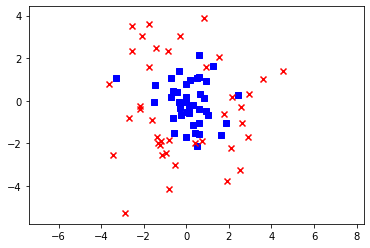

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from dataset2_logreg import DataSet  

#get and plot the data
y_D,x_D = DataSet.get_data()
DataSet.plot_data()
plt.show()

def ce_cost(x_arr, y_arr, predict_f):       #计算 cross entropy cost
  y_eq_0 = (y_arr==0).nonzero()[1]
  y_eq_1 = (y_arr==1).nonzero()[1]
  a = predict_f(x_arr)
  cost = np.sum( -np.log2(a[0][y_eq_1])) + np.sum( -np.log2(1-a[0][y_eq_0]))
  return cost

We can not use the class `NNet` since the  back-propagation algorithm was implemented for the L2 cost (in fact we could, but the cost will be higher). Since we are using the cross-entropy loss, the back-propagation has to be modified to optimize this cost function. 

1. Modify the back-propagation presented below such that it follows computes the gradient of the cross-entropy loss. Where does the cost function enter the back-propagation? (You can check the lecture notes and derive the back-propagation for cross-entropy loss)

In [10]:
def bp(self, x, y):
    """
    Backpropagation. Uses the current parameters W, b
    Args:
        x = np.array of size self.layers[0] x N (contains N input vectors from the training set)
        y = np.array of size self.layers[L] x N (contains N output vectors from the training set)
    Returns:
        dW = dictionary corresponding to W, where each corresponding key contains a matrix of the 
             same size, eg, W[i].shape = dW[i].shape for all i. It contains the partial derivatives
             of the cost function with respect to each entry entry of W.
        db = dictionary corresponding to b, where each corresponding key contains a matrix of the 
             same size, eg, b[i].shape = bW[i].shape for all i. It contains the partial derivatives
             of the cost function with respect to each entry entry of b. 
        
    """
		### MODIFY SOMETHING BELOW ###
    a,z = self.fp(x)
    L = self.L
    
    dCdz = { L: (a[L]-y)/a[L]/(1-a[L])*self.d_act_out(z[L]) }
    for l in range(L-1,0,-1):        # 从L-1 到 0； ‘-1’ 表示倒序
        dCdz[l] = self.W[l+1].T.dot(dCdz[l+1]) * self.d_act_hid(z[l])
        
    db = {}
    for l in range(1,L+1):
        db[l] = np.sum(dCdz[l], axis=1).reshape((-1,1))
        
    dW = {}
    for l in range(1,L+1):
        dW[l] = dCdz[l].dot(a[l-1].T)
   ### MODIFY SOMETHING ABOVE ###		
    return dW, db
  
  
#adding the modified back-prop to the class
NNet.bp = bp  

Once the back-propagation was corrected for binary classifiacion,  we initialize the network and run the GD learning to find the model parameters.

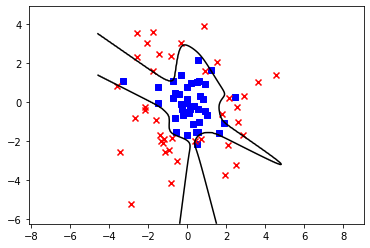

Cost:7.746013


In [11]:
NN = NNet((2,6,6,1), sigmoid, d_sigmoid, sigmoid, d_sigmoid)  

NN.gd_learn(50000, 0.01, x_D, y_D)

#plot and compute cost
DataSet.plot_decision_boundary(NN.output)
plt.show()
print('Cost:%f' % ce_cost(x_D, y_D, NN.output)) 

## Problem 3 - Regularization of NNs
We now add the regularization term to the cost function which results in the cost function
$$ C = \sum_{i=1}^{N} C_i + \sum_{l=1}^{L} \lambda \|\mat{W}^{[l]}\|^2= \sum_{i=1}^{N} -y_i \log(a_i)  -(1-y_i)\log(1-a_i) + \sum_{l=1}^{L} \lambda \|\mat{W}^{[l]}\|^2, $$ 
where $\|\mat{W}^{[l]}\|^2 = \sum_{i,j} \left(w_{i,j}^{[l]}\right)^2$. That is, the regularization corresponds to adding the sum of the squares of the entries from the matrices $\mat{W}^{[1]},\dotsc,\mat{W}^{[L]}$. Note that we do not normalize the bias terms.

1. Derive the expression for the gradient for the cost function with the regularization. It could be done using the method form the lecture (differentiation with respect to rows of $\mat{W}^{[l]}$). Finally, we obtain
	$$\frac{\partial C}{\partial \mat{W}^{[l]}} = \sum_{i=1}^{N} \frac{\partial C^{(i)}}{\partial \mat{W}^{[l]}} + 2\lambda \mat{W}^{[l]} =\sum_{i=1}^{N} \left( \vec{a}^{[l-1]} \frac{\partial C^{(i)}}{\partial \vec{z}^{[l]}}\right)^T + 2\lambda \mat{W}^{[l]}$$

2. Using the above expression, we observe that it suffices to modify the `gd_learn` function to perform a regularized optimization. Modifiy the `gd_learn` function such that it uses the gradients with regularization. `lbd` denotes the regularization parameter.

In [12]:
def gd_learn(self, iter_num, l_rate, x, y, lbd=0):  #上式右边等号第一项相当于是dW[n],第二项相当于是正则化项. b不变
    """                                                             
    Performs gradient descent learning.        
    """
    ### YOUR CODE HERE ###
 
    for i in range(iter_num):
        dW, db = self.bp(x, y)
        for n in range(1, self.L):
            self.W[n] = self.W[n] - l_rate*(dW[n] + 2*lbd*self.W[n])
            self.b[n] = self.b[n] - l_rate*db[n]
       
    #####################
    return 0    

#adding the modified gd_learn to the class
NNet.gd_learn = gd_learn

Now we train the network with regularization parambeter $\lambda = 0.07$

/Users/goffery/Desktop/Machine Learning for Communications/Tutorial/3/dataset2_logreg.py:55: UserWarning: No contour levels were found within the data range.
  plt.contour(x0_grid, x1_grid, a, [0.5], colors=('k',))


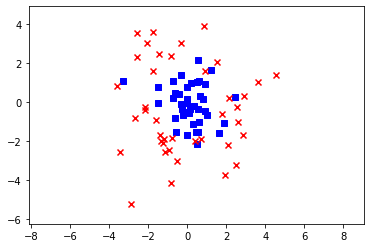

Cost:81.301304


In [13]:
lbd = 0.07
NN = NNet((2,6,6,1), sigmoid, d_sigmoid, sigmoid, d_sigmoid)  

NN.gd_learn(50000, 0.05, x_D, y_D, lbd)

#plot and compute cost
DataSet.plot_decision_boundary(NN.output)
plt.show()
print('Cost:%f' % ce_cost(x_D, y_D, NN.output))     #No contour levels were found within the data range.？？安装pytorch